In [1661]:
import numpy as np
from torch.autograd import Variable
import torch
import random
from typing import List, Callable, Iterable
import matplotlib.pyplot as plt
import time
import numdifftools as nd

seed = 999
torch.manual_seed(seed)
random.seed(seed)


## Linearization Method

In [1662]:
import scipy.optimize as opt
from scipy.optimize import LinearConstraint, NonlinearConstraint, Bounds

In [1663]:
def Gradient(func: Callable, X):
    return nd.Gradient(func)(X)
def Derivative(func: Callable, X, order):
    return nd.Derivative(func, n=order)(X)
def ReLu(x):
    return 0 if x < 0 else x
def Loss(obj, constraints, X, penalty=1):
    return obj(X) + penalty * sum([ReLu(con(X)) for con in constraints])

In [1664]:
'''
δ, subscript of I(X), should be non-negative
inf implies I_δ(X) == I(X)
'''
DELTA = np.inf 
N = 1
EPSILON = 0.5

LOSS_PENALITY = 10000

In [1665]:
def Initialize(setting=1):
    if setting == 1:
        X = [np.array([3.0, -2.0]), np.array([-4.0, 9.0])]
        obj = lambda X: (X[1]**2)-3
        cons =[
            lambda X: 0.0, # the assumption on the top of page 44
            lambda X: 10**X[0] - 1e-1,
            lambda X: 10**X[1] - 1e-3,
            # lambda X: -(X**2).sum() + 20,
        ]
    elif setting == 2:
        X = [np.array([3.0, -2.0]), np.array([3.0, -20.0],)]
        obj = lambda X: (X[1]**2)-3
        cons =[
            lambda X: 0.0, # the assumption on the top of page 44
            lambda X: 10**X[0] - 1e-1,
            lambda X: 10**X[1] - 1e-3,
            lambda X: (X**2).sum() - 20,
        ]
    elif setting == 3   :   
        X = [np.array([30.0, -8.0]), np.array([-100.0, 5.0])]
        obj = lambda X: Ｘ[0]**2 + X[1]**2 + 10
        cons =[
            lambda X: 0.0, # the assumption on the top of page 44
            lambda X: (X**6).sum() - 20,
            lambda X: (X**2).sum() - 10,
            lambda X: (X[1]**8) - 20,
            lambda X: X.sum() - 10,
            lambda X: 3*X[0] - 2*X[1] + 1,
        ]

    # initial guess
    

    # real answer
    for x in X:
        res = opt.minimize(obj, x, constraints=[NonlinearConstraint(i, -np.inf, 0) for i in cons])
        # print(res)
        assert(res.success)
    return obj, cons, X

obj, cons, X = Initialize()

In [1666]:

# Our ans


def FindP(X, constraints):
    '''Find I_δ(X)'''
    assert(len(constraints) > 0)
    F = lambda X: max([f(X) for f in constraints])
    I_delta = []
    for i, f_i in enumerate(constraints):
        if f_i(X) >= F(X) - DELTA:
            I_delta.append(i)
    '''approximate objective'''
    quad_obj = lambda p: np.dot(Gradient(obj, X), p) + 0.5*np.dot(p, p)

    '''approximate constraints'''
    grad_of_cons = []
    val_of_cons = []
    for i in I_delta:
        val_of_cons.append(constraints[i](X))
        grad_of_cons.append(Gradient(constraints[i], X))

    # linear_cons = [np.dot(grad, p) + val for grad, val in zip(grad_of_cons, val_of_cons)]

    res = opt.minimize(quad_obj, X, constraints=[LinearConstraint(grad, -np.inf, -val) for grad, val in zip(grad_of_cons, val_of_cons)])
    if not res.success:
        print(res)
        raise(BaseException)
    p = (res.x) # solution of the quadratic programming problem
    return p, F

def HonestOptimize(X, all_constraints):
    # print("---> HonestOptimize <---")
    p, F = FindP(X, all_constraints)
    '''gradient filter'''
    '''g_i(w) = f_i(x + w * p), w is scalar '''
    faulty_constraints = []
    honest_constraints = []
    gd_filter_threshold = 10
    for i in range(len(all_constraints)):
        g_i = lambda w: all_constraints[i](X + w*p)
        if Derivative(g_i, 0, order=2) > gd_filter_threshold:
            faulty_constraints.append(all_constraints[i])
            # print(f'fault: {i}')
        else:
            honest_constraints.append(all_constraints[i])
        # print(f'{Derivative(g_i, 0, order=2)}_{X}')
    assert(len(honest_constraints) > 0)
    p, F = FindP(X, honest_constraints)
    alpha = 1
    # if (len(honest_constraints) == len(all_constraints)):
    #     while obj(X + alpha*p) + N*F(X + alpha*p) > obj(X) + N*F(X) - alpha*EPSILON*np.dot(p, p):
    #         alpha /= 2

    X += alpha*p
    # print(f'obj: {obj(X)}, X: ({X[0]:4f}, {X[1]:4f}), alpha: {alpha}, |p|: {sum(p**2):4f}', end='\n')
    # print("---> Done <---")
    return X, faulty_constraints

def BizantineOptimization(X, faulty_constraints):
    # print("---> BizantineOptimization <---")
    k = 50  # constant > 0
    t = 50  # constant > 0

    if len(faulty_constraints) == 0:
        # print("---> No Fault Done <---")
        return X
    new_obj = lambda U: obj(U) + k * sum([ReLu(con(U)) for con in faulty_constraints])\
                        + 1/(2*t) * np.square(U-X).sum()
    res = opt.minimize(new_obj, X, method='Nelder-Mead')
    if not res.success:
        # print(res)
        raise(BaseException)
    # print(res)
    # print("---> Done <---")
    return res.x
    



[ 3. -2.]
[-4.  9.]


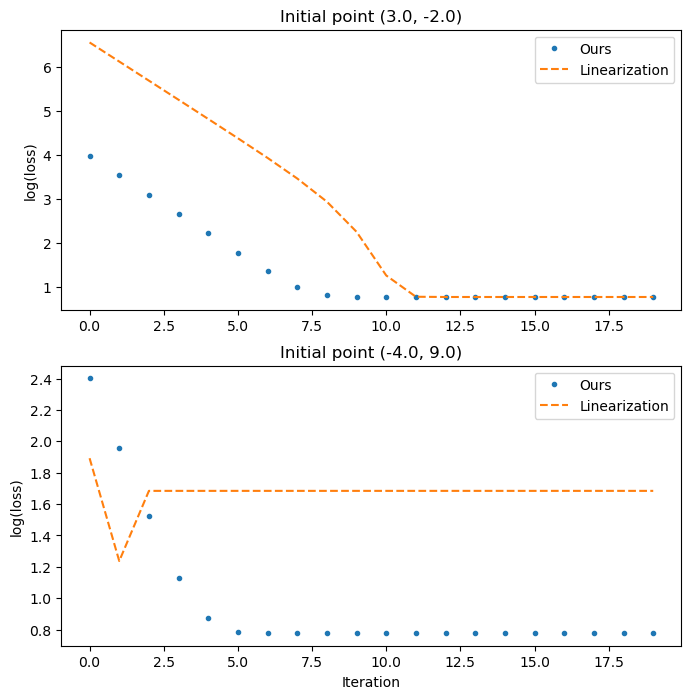

[ 3. -2.]
[  3. -20.]


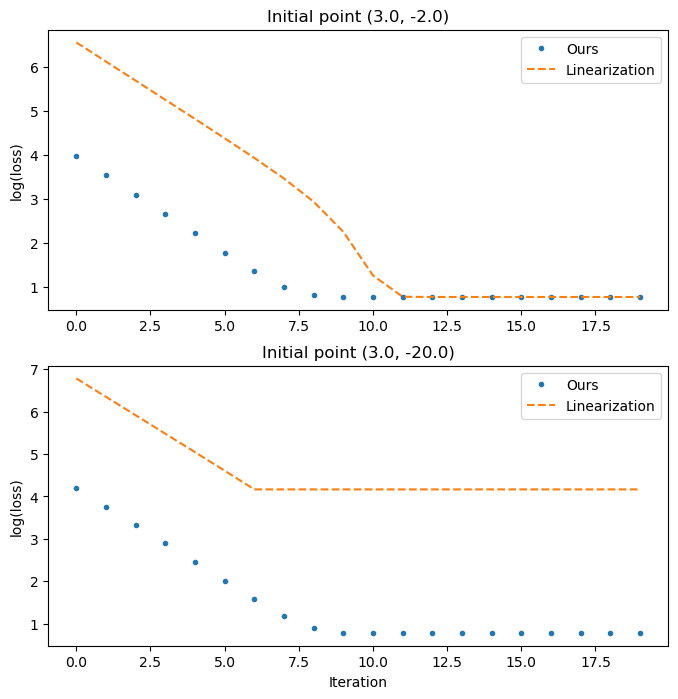

[30. -8.]
[-100.    5.]


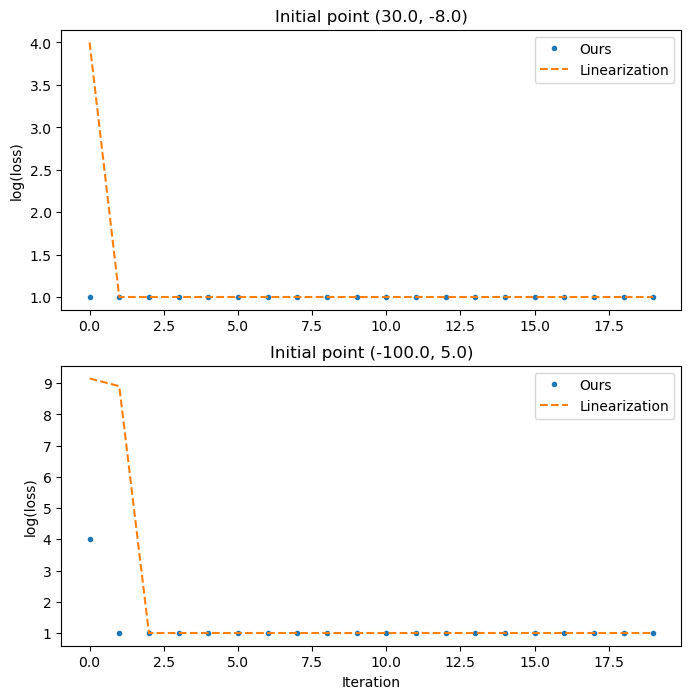

In [1667]:
# Optimization 
num_iterate = 20
for setting in range(1,4):
    obj, cons, X_list = Initialize(setting)
    fig, axs = plt.subplots(len(X_list), 1, figsize =(8, 8))
    for j, x in enumerate(X_list):
        X = x.copy()
        print(x)
        our_losses = []
        for _ in range(num_iterate):
            # print(X)
            X, faulty_constraints = HonestOptimize(X, cons)
            # print(X)
            X = BizantineOptimization(X, faulty_constraints)
            loss = Loss(obj, cons, X, penalty=LOSS_PENALITY)
            our_losses.append(loss)
            # print(f'iter: {_} | obj:{obj(X):4f} | X: {X} | loss: {loss:4f}')
            
        linear_losses = []
        X = x.copy()
        for _ in range(num_iterate):
            p, F = FindP(X, cons)
            alpha = 1
            while obj(X + alpha*p) + N*F(X + alpha*p) > obj(X) + N*F(X) - alpha*EPSILON*np.dot(p, p):
                alpha /= 2

            X += alpha*p
            loss = Loss(obj, cons, X, penalty=LOSS_PENALITY)
            linear_losses.append(loss)
            # print(f'{_}  obj: {obj(X)}, X: ({X[0]:4f}, {X[1]:4f}), alpha: {alpha}, |p|: {sum(p**2):4f}', end='\n')
        axs[j].plot(range(num_iterate), np.log10(our_losses), '.', label='Ours')
        axs[j].plot(range(num_iterate), np.log10(linear_losses), '--', label='Linearization')
        # axs[j].set_xlabel('Iteration')
        axs[j].set_ylabel('log(loss)')
        axs[j].set_title(f'Initial point ({x[0]}, {x[1]})')
        axs[j].legend()
        # print(x, X_list[j], len(X_list), print())
    plt.xlabel('Iteration')
    plt.show()


In [1668]:
Initialize(2)

(<function __main__.Initialize.<locals>.<lambda>(X)>,
 [<function __main__.Initialize.<locals>.<lambda>(X)>,
  <function __main__.Initialize.<locals>.<lambda>(X)>,
  <function __main__.Initialize.<locals>.<lambda>(X)>,
  <function __main__.Initialize.<locals>.<lambda>(X)>],
 [array([ 3., -2.]), array([  3., -20.])])